##### Concurrency and interaction  2024/2025
### Lecture 4 - Grover's algorithm

1. [Grover's Algorithm](#Grover) <p>
   a.  [Unstructured search](#unstructured-search) <p>
   b.  [Oracle](#oracle_intro) <p>
   c.  [Amplitude Amplification](#amplitude_amp) <p>
2. [Grover's algorithm with 2 qubits](#grover2)
3. [Grover's algorithm with 3 qubits](#grover3)
4. [Amplitude Amplification and multiple winner states](#multiple)
5. [Removing the ancilla](#ancilla)

## 1. Grover's algorithm <a id="grover"></a>

Grover's algorithm is one of the most powerful quantum algorithms. The algorithm is known for a quadratic speed up in searching for an element in an **unstructured database**. 

Grover's algorithm can be used in any problem that can be restated as an unstructured search problem:

* Finding minimum/maximum/mean 
* Collision problem 
* Satisfiability 
* Optimization in general. 

### a. Unstructured Search <a id="unstructured-search"></a>

Suppose you have an array of $N$ items. Consider that $w$ for winner is the element we want to find. 

![image1](images/list.png)

Classic $\quad \Rightarrow \quad \mathcal{O}(N)$

Quantum $\quad \Rightarrow \quad \mathcal{O}(\sqrt{N})$

### b. Oracle

Notice that we want to exploit the superposition principle, therefore, all entries in the above database will happen at the same time! Thus, for us, the database is composed by all computational basis states our qubits can be in.

The oracle $U_w$ adds a negative phase to the solution states i.e. for any state $|x\rangle$ in the computational basis corresponding to the winner:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

we can use an ancilla to store the result of the function! 


Similar to Deutsch-Jozsa, we initialize the 'output' qubit in the state $|{-}\rangle$, and the phase kickback effect do the rest.
</p><p>  

![image1](images/function.png)


Now, the goal is to find a routine that amplifies the probability of measuring the winner state! 

### c. Amplitude Amplification <a id="amplitude_amp"></a>

The Diffusion operator $D$ is a reflection about the mean of the amplitudes. It is defined as:

$$D = 2|DB \rangle \langle DB| - I$$

where |DB\rangle is the database superposition quantum state. D amplifies the amplitude of the winner state.

Full Grover's circuit is:
![image5](images/full_circuit.png)

## 2. Grover's algorithm with 2 qubits <a id="grover2"></a>

Let's suppose we want to find the state $|11\rangle$.
Build the Grover's algorithm and check the probabilities 

In [ ]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3 , shots = 100)

@qml.qnode(dev)
def grover(iterations=1):

    #create registers 
    db = [0,1]
    ancilla=[2]

    #superposition
    for i in db:
        qml.Hadamard(wires=i)
    #qml.broadcast(qml.Hadamard , wires=db , pattern="single")
    
    qml.PauliX(wires=ancilla)
    qml.Hadamard(wires=ancilla)


    for it in range(iterations):
        #oracle
        qml.Toffoli(wires=[db[0],db[1],ancilla[0]])

        qml.broadcast(qml.PauliX , wires=db , pattern="single")
        qml.Toffoli(wires=[db[0],db[1],ancilla[0]])
        qml.broadcast(qml.PauliX , wires=db , pattern="single")


        #or using the MultiControlledX gate with control state
        #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register, control_values=id)

        #diffusion
        # use  qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1]) for a general implementation
        for i in db:
            qml.Hadamard(wires=i)
        
            #for i in db:
            qml.PauliX(wires=i)

        qml.CZ(wires=[db[0],db[1]])

        for i in db:
            qml.PauliX(wires=i)

            #for i in db:
            qml.Hadamard(wires=i)
    

    #measurement
    return qml.probs(wires=db)


(<Figure size 1700x400 with 1 Axes>, <Axes: >)

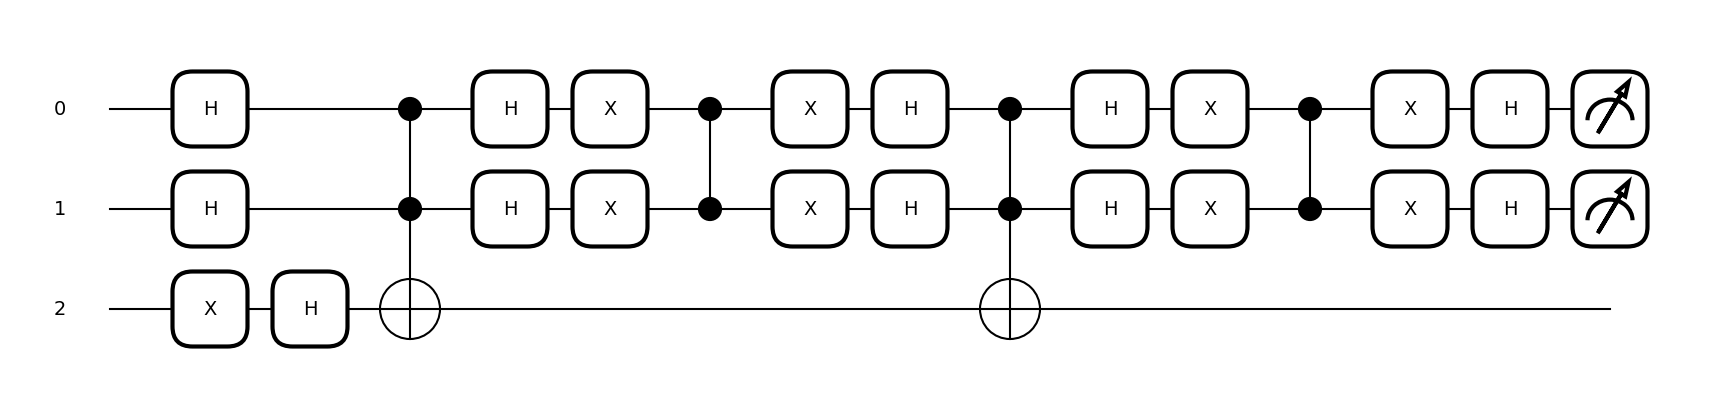

In [30]:
#visualize the circuit

qml.draw_mpl(grover)(iterations=2)




Text(0.5, 1.0, 'Probability Distribution')

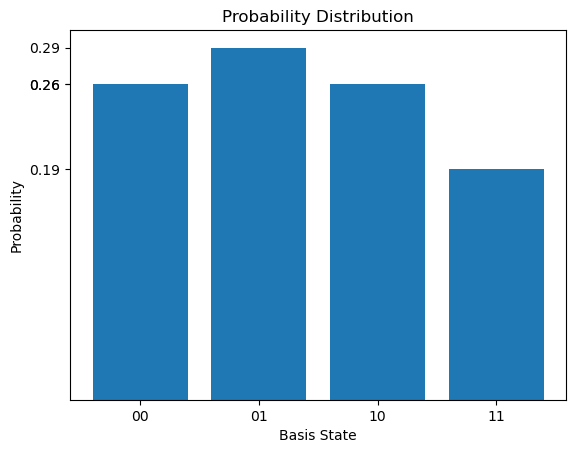

In [31]:
#Run the algorithm
n_qubits = 2

probs = grover(iterations=2)

#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)
plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")


## 3. Grover's algorithm with 3 qubits <a id="grover3"></a>  


Let's suppose we want to find the state $|011\rangle$. Run Grover's algorithm and check the probabilities.

In [32]:
#Run the algorithm and visualize the probability histogram

def grover(n_qubits, id, iterations="optimal"):

    #create registers 
    input_registers = range(n_qubits)
    ancilla_register = [n_qubits]

    #superposition
    qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")

    qml.PauliX(wires=ancilla_register)
    qml.Hadamard(wires=ancilla_register)

    qml.Barrier()

    if iterations == "optimal":
        its = round(np.pi/4*np.sqrt(2**n_qubits) - 0.5)
    else:
        its = iterations
        
    for _ in range(its):
        #oracle
        for i,k in enumerate(id):
            if k == 0:
                qml.PauliX(wires=input_registers[i])
        qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register)
        for i,k in enumerate(id):
            if k == 0:
                qml.PauliX(wires=input_registers[i])

        #or using the MultiControlledX gate with control state
        #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register, control_values=id)

        qml.Barrier()
        
        #diffusion
        qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")
        qml.broadcast(qml.PauliX, wires=input_registers, pattern="single")
        qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1])
        qml.broadcast(qml.PauliX, wires=input_registers, pattern="single")
        qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")

        qml.Barrier()
    

    #measurement
    return qml.probs(wires=input_registers) 

/opt/homebrew/Caskroom/miniforge/base/envs/jaxqrl/lib/python3.9/site-packages/pennylane/ops/op_math/controlled_ops.py:1103: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jaxqrl/lib/python3.9/site-packages/pennylane/ops/op_math/controlled_ops.py:1103: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


(<Figure size 1600x600 with 1 Axes>, <Axes: >)

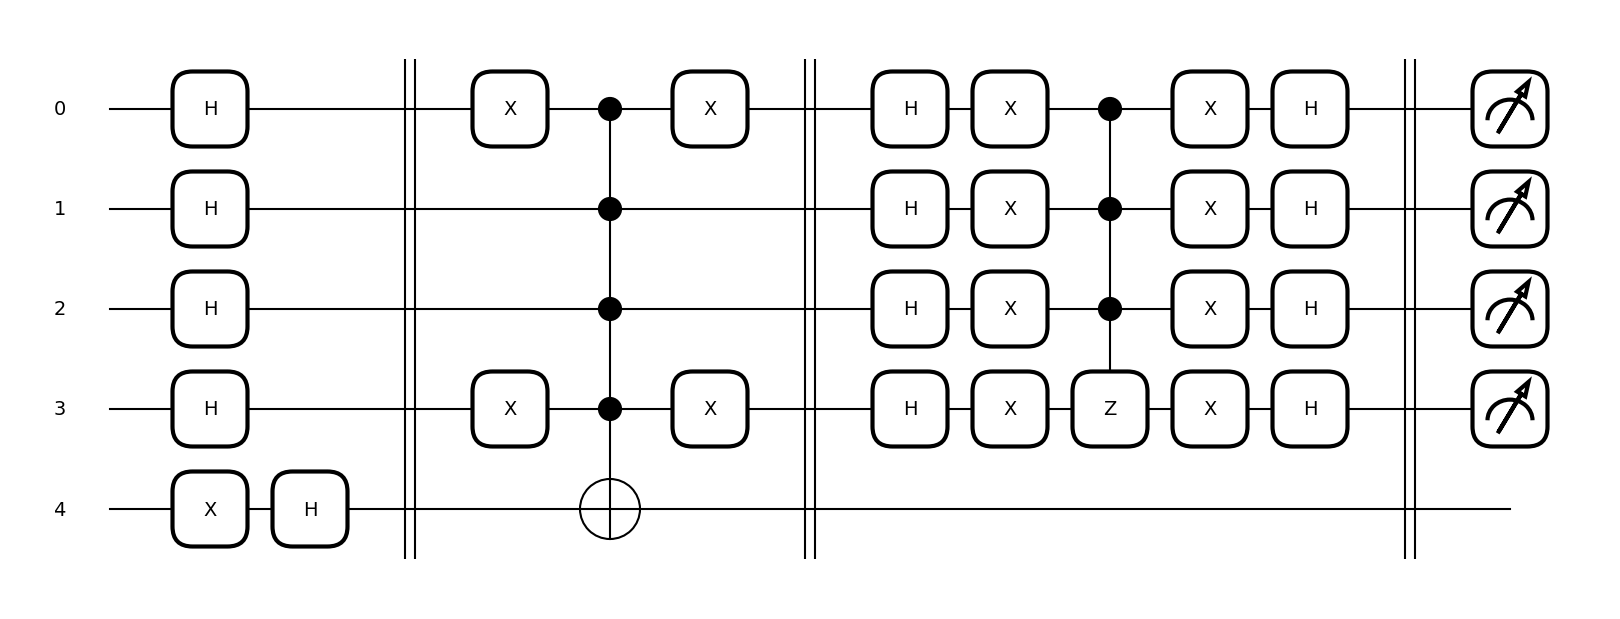

In [39]:
#Run the algorithm

n_qubits = 4
id = [0,1,1,0]

dev = qml.device("default.qubit", wires=n_qubits+1)

Grover = qml.QNode(grover, dev)

probs = Grover(n_qubits, id, iterations=1)


qml.draw_mpl(Grover)(n_qubits, id, iterations=1)



Text(0.5, 1.0, 'Probability Distribution')

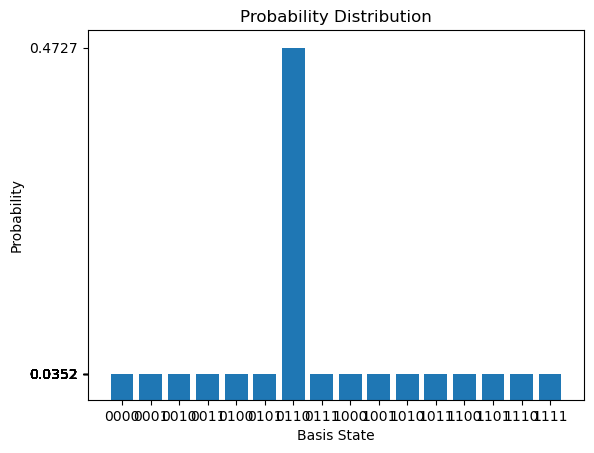

In [40]:
#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)

plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")

## 4. Amplitude Amplification and multiple winner states <a id="multiple"></a>

1) Let's suppose we want to find one of the states $\{|000\rangle , |001\rangle \}$. 
2) Let's suppose we want to find one of the states $\{|0000\rangle , |0010\rangle , |0100\rangle , |1000\rangle \}$.

What do 1) and 2) have in common?

In [41]:
#Run the algorithm and visualize the probability histogram

def grover(n_qubits, ids, iterations="optimal"):

    #create registers 
    input_registers = range(n_qubits)
    ancilla_register = [n_qubits]

    #superposition
    qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")

    qml.PauliX(wires=ancilla_register)
    qml.Hadamard(wires=ancilla_register)

    qml.Barrier()

    if iterations == "optimal":
        its = round(np.pi/4*np.sqrt(2**n_qubits/len(ids)) - 0.5)
    else:
        its = iterations
        
    for _ in range(its):
        #oracle

        for id in ids:
            for i,k in enumerate(id):
                if k == 0:
                    qml.PauliX(wires=input_registers[i])
            qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register)
            for i,k in enumerate(id):
                if k == 0:
                    qml.PauliX(wires=input_registers[i])

        #or using the MultiControlledX gate with control state
        #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register, control_values=id)

        qml.Barrier()
        
        #diffusion
        qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")
        qml.broadcast(qml.PauliX, wires=input_registers, pattern="single")
        qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1])
        qml.broadcast(qml.PauliX, wires=input_registers, pattern="single")
        qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")

        qml.Barrier()
    

    #measurement
    return qml.probs(wires=input_registers)

/opt/homebrew/Caskroom/miniforge/base/envs/jaxqrl/lib/python3.9/site-packages/pennylane/ops/op_math/controlled_ops.py:1103: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jaxqrl/lib/python3.9/site-packages/pennylane/ops/op_math/controlled_ops.py:1103: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


(<Figure size 2100x600 with 1 Axes>, <Axes: >)

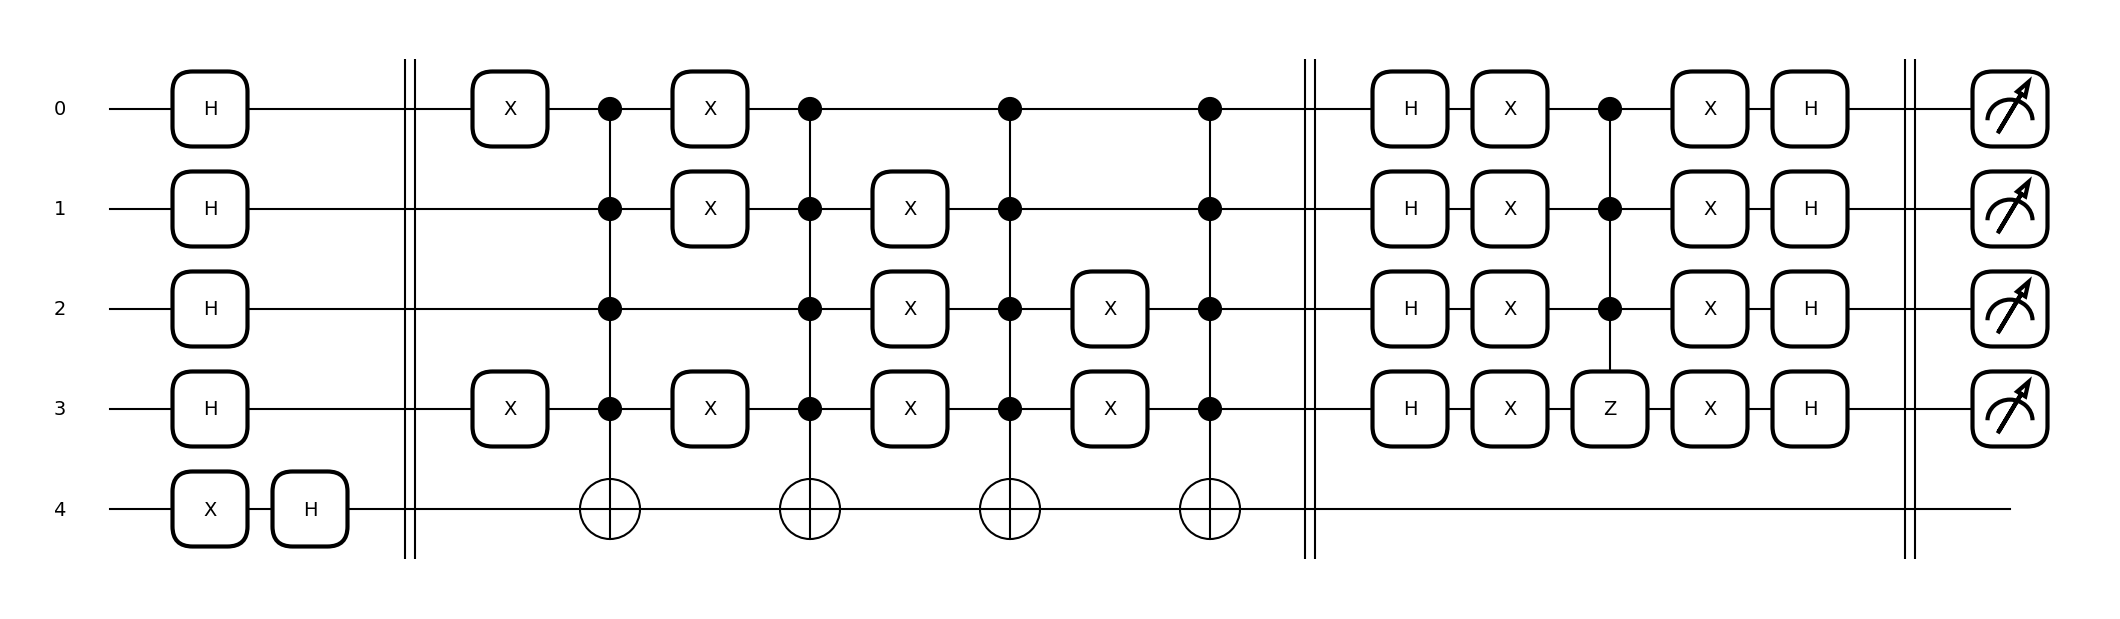

In [45]:
#Run the algorithm
n_qubits = 4
ids = [[0,1,1,0],[1,0,1,1], [1,1,0,0], [1,1,1,1]]

dev = qml.device("default.qubit", wires=n_qubits+1)
Grover = qml.QNode(grover, dev)

probs = Grover(n_qubits, ids, iterations=1)


qml.draw_mpl(Grover)(n_qubits, ids, iterations=1)


Text(0.5, 1.0, 'Probability Distribution')

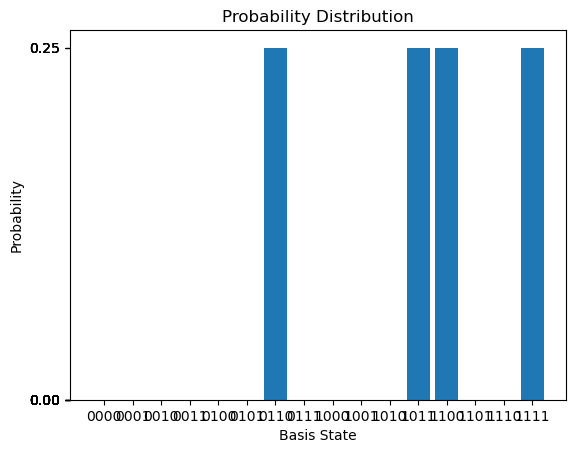

In [46]:
#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)

plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")

## 5. Removing the ancilla <a id="ancilla"></a>

Rewrite the Grover's algorithm without the ancilla qubit - find one of the states $\{|0000\rangle , |0010\rangle , |0100\rangle , |1000\rangle \}$.

In [21]:
#Run the algorithm and visualize the probability histogram

def grover(n_qubits, ids, iterations="optimal"):

    #create registers 
    input_registers = range(n_qubits)
    #ancilla_register = [n_qubits]

    #superposition
    qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")

    #qml.PauliX(wires=ancilla_register)
    #qml.Hadamard(wires=ancilla_register)

    qml.Barrier()

    if iterations == "optimal":
        its = round(np.pi/4*np.sqrt(2**n_qubits/len(ids)) - 0.5)
    else:
        its = iterations
        
    for _ in range(its):
        #oracle

        for id in ids:
            for i,k in enumerate(id):
                if k == 0:
                    qml.PauliX(wires=input_registers[i])
            #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register)
            qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1])

            for i,k in enumerate(id):
                if k == 0:
                    qml.PauliX(wires=input_registers[i])

        #or using the MultiControlledX gate with control state
        #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register, control_values=id)

        qml.Barrier()
        
        #diffusion
        qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")
        qml.broadcast(qml.PauliX, wires=input_registers, pattern="single")
        qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1])
        qml.broadcast(qml.PauliX, wires=input_registers, pattern="single")
        qml.broadcast(qml.Hadamard, wires=input_registers, pattern="single")

        qml.Barrier()
    

    #measurement
    return qml.probs(wires=input_registers)

(<Figure size 1700x400 with 1 Axes>, <Axes: >)

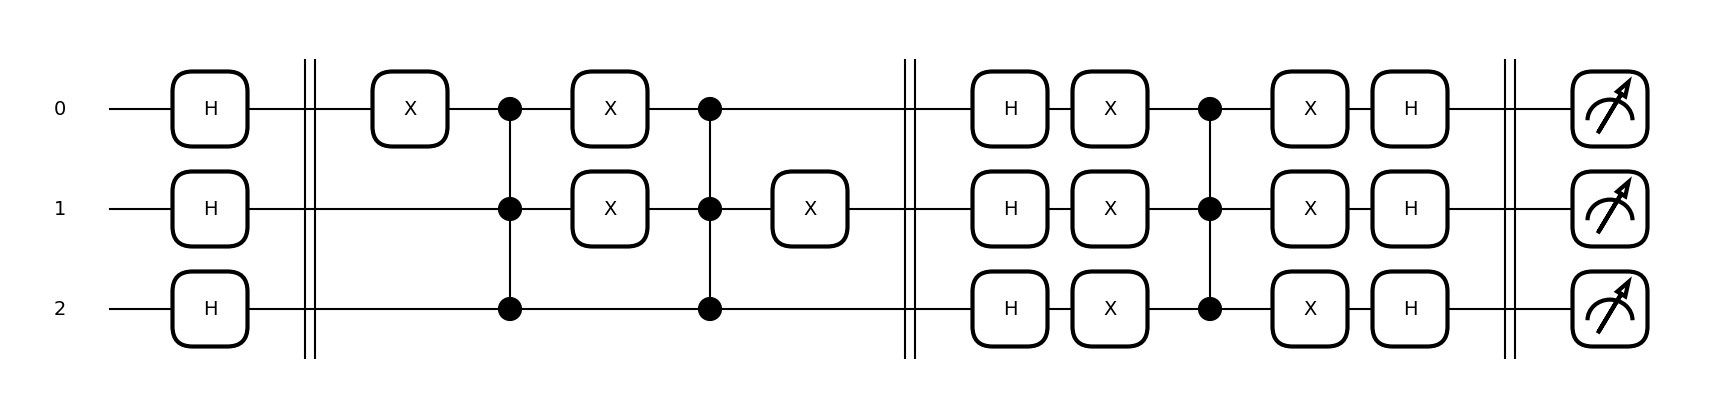

In [22]:
#Run the algorithm
n_qubits = 3
ids = [[0,1,1],[1,0,1]]

dev = qml.device("default.qubit", wires=n_qubits+1)
Grover = qml.QNode(grover, dev)

probs = Grover(n_qubits, ids, iterations="optimal")


qml.draw_mpl(Grover)(n_qubits, ids, iterations="optimal")


Text(0.5, 1.0, 'Probability Distribution')

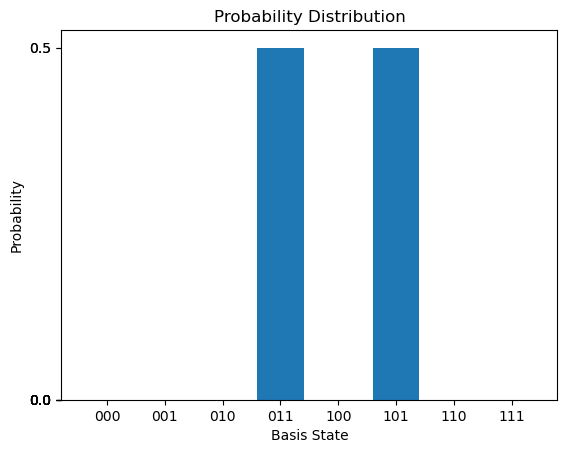

In [23]:
#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)

plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")